# Chapter 3. Reinforcement Learning Problem
In this tutorial we go through the example of computing action-value
function and state-value function following the example given in Chapter 3
of `Reinforcement Learning: An Introduction`.

State value function and action value function for policy $\pi$ are defined
as follow

\begin{align*}
v_{\pi} (s)
  &= \mathbb{E}_{\pi} \lbrack G_t | S_t = s \rbrack \\
q_{\pi}(s, a)
  &= \mathbb{E}_{\pi} \lbrack G_t | S_t = s, A_t = a \rbrack \\
\text{where } & \text{$G_t$ , the sum of the discounted rewards, is} \\
G_t
  &= R_{t+1} + R_{t+2} + R_{t+3} + \dots + R_{T}
\end{align*}

In case of Markov Decision Process, the following can be derived.

\begin{align*}
v_{\pi} (s)
  &= \mathbb{E}_{\pi} \lbrack G_t | S_t = s \rbrack \\
  &= \mathbb{E}_{\pi} \lbrack \sum_{k=0}^{\infty}
     \gamma ^ {k} R_{t+k+1} | S_t = s \rbrack \\
q_{\pi}(s, a)
  &= \mathbb{E}_{\pi} \lbrack G_t | S_t = s, A_t = a \rbrack \\
  &= \mathbb{E}_{\pi} \lbrack \sum_{k=0}^{\infty}
     \gamma ^ {k} R_{t+k+1} | S_t = s, A_t = a \rbrack
\end{align*}

These interweived functions statisfy recursive relationships as follow

\begin{align*}
v_{\pi} (s)
  &= \mathbb{E}_{\pi} \lbrack G_t | S_t = s \rbrack \\
  &= \mathbb{E}_{\pi} \lbrack
     \sum_{k=0}^{\infty} \gamma ^ k R_{t+k+1} | S_t = s \rbrack \\
  &= \mathbb{E}_{\pi} \lbrack
     R_{t+1} + \gamma
     \sum_{k=0}^{\infty} \gamma ^ k R_{t+k+2} | S_t = s \rbrack \\
  &= \sum_a \pi(a|s) \sum_{s'} p(s' |s, a) \lbrack
     r(s, a, s') + \gamma \mathbb{E}_{\pi} \lbrack
         \sum_{k=0}^{\infty} \gamma^{k} R_{t+k+2} | S_{t+1} = s'
       \rbrack
     \rbrack \\
  &= \sum_a \pi(a|s) \sum_{s'} p(s' |s, a) \lbrack
     r(s, a, s') + \gamma v_{\pi}(s')
     \rbrack
\end{align*}

Let us compute and visualize the state-value function through GridWorld
example.
For the detail of the definition, please refer to the Example 3.8
from the book.
- Agent moves in 5 x 5 grid cell
- Agent takes action to move either north, east, west, or south.
- Actions that would move the agent out of grid results in reward of -1
and agent stays where it was before taking the action.
- On success full action, agent moves to new position and receives
0 reward.
- In special state $A$ (0, 1), all action cause the agent to move to $A'$
(4, 1) and reward of 10
- Similarly in $B$ (0, 3), all action cause the agent to move to $B'$
(2, 3) and reward of 5

First, we define `GridWorld` environment as follow

In [1]:
from __future__ import print_function
from __future__ import absolute_import

import numpy as np
import matplotlib.pyplot as plt

import luchador.env
import luchador.agent
from luchador.episode_runner import EpisodeRunner


def _transit(position, action):
    """Transition rule of GridWorld

    Parameters
    ----------
    position : NumPy NDArray
        Coordinate of agent
    action : int
        0, 1, 2, or 3, meaning north, east, west or south respectively

    Returns
    -------
    NumPy NDArray
        New coordinate
    int
        Reward
    """
    reward = 0
    new_position = position.copy()

    if np.all(position == [0, 1]):
        reward = 10
        new_position[:] = [4, 1]
        return new_position, reward
    if np.all(position == [0, 3]):
        reward = 5
        new_position[:] = [2, 3]
        return new_position, reward

    if action == 0:  # North
        move = [0, 1]
    elif action == 1:  # East
        move = [1, 0]
    elif action == 2:  # West
        move = [-1, 0]
    elif action == 3:  # South
        move = [0, -1]

    new_position = new_position + move
    if np.any(new_position < 0) or np.any(new_position > 4):
        reward = -1
        new_position[new_position < 0] = 0
        new_position[new_position > 4] = 4
    return new_position, reward


class GridWorld(luchador.env.BaseEnvironment):
    """GridWorld Example from Sutton, Chapter3."""
    def __init__(self, seed=None):
        self.position = None
        self.rng = np.random.RandomState(seed=seed)

    @property
    def n_actions(self):
        return 4

    def reset(self):
        """Reset position randomly"""
        self.position = self.rng.randint(5, size=2)
        return luchador.env.Outcome(
            reward=0, observation=self.position, terminal=False, state={})

    def step(self, action):
        """Move position based on action and transit rule"""
        self.position, reward = _transit(self.position, action)
        return luchador.env.Outcome(
            reward=reward, observation=self.position, terminal=False, state={})

Then we create agent which
- has equiprobable random policy
- estimates of action-value function via Monte-Calro approach

State value:
 [[ 3.30569427  8.78699243  4.42331714  5.31994367  1.48825901]
 [ 1.51852186  2.98933434  2.24694127  1.90463769  0.54457414]
 [ 0.04807821  0.7357133   0.67082204  0.3561573  -0.40502529]
 [-0.97596873 -0.43738304 -0.35655831 -0.5870724  -1.18447799]
 [-1.85956492 -1.34676746 -1.23060778 -1.42413428 -1.97638474]]


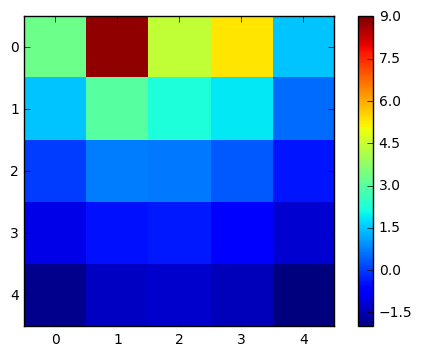

In [2]:
class GridWorldAgent(luchador.agent.BaseAgent):
    """Agent walk on GridWorld with equiprobable random policy

    Parameters
    ----------
    alpha : float
        StepSize parameter for estimating action value function
    gamma : float
        Discount rate for computing state-value function
    """
    def __init__(self, alpha=0.9, gamma=0.9, seed=None):
        self.alpha = alpha
        self.gamma = gamma

        self.position = None
        self.rng = np.random.RandomState(seed=seed)
        self.action_values = np.zeros((5, 5, 4))

    def init(self, _):
        pass

    def reset(self, observation):
        self.position = observation

    def observe(self, action, outcome):
        pos0 = self.position
        pos1 = outcome.observation

        post_state_value = np.mean(self.action_values[pos1[0], pos1[1]])
        target = outcome.reward + self.gamma * post_state_value
        self.action_values[pos0[0], pos0[1], action] += self.alpha * (
            target - self.action_values[pos0[0], pos0[1], action])
        self.position = pos1

    def act(self):
        return np.random.choice(4)


env = GridWorld(seed=0)
agent = GridWorldAgent(seed=123)
runner = EpisodeRunner(env, agent)

runner.run_episode(max_steps=10000)

state_value = np.mean(agent.action_values, axis=2)
print('State value:\n', state_value)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
img = ax.imshow(state_value, vmin=-2.0, vmax=9.0,
                interpolation='nearest', origin='upper', animated=True)
fig.colorbar(img)
plt.show(block=False)